# San Francisco Airbnb Data Analysis
## by Jingjun He


![title](airbnb-678x381.jpg)

Airbnb has quickly become a popular non-traditional accommodations which gives travelers unique and personalized experience of the local culture that different from staying in hotel room. It allows travelers to rent apartments or houses from people all over the world with their own preferences on price and experience. While expanding traveling possibilities for travelers, it also provides homeowners new approach to expand their income stream. Assuming I have additional cash that I'd like to invest in another property in San Francisco as a vocation house and list the house on Airbnb when not in use. As an inspiring data analyst, I want to do my own research before seeking advice from a real estate agent. I've gathered San Francisco Airbnb listing data, crime incidents and house sales price data from different sources. By exploring and analyzing these datasets, I'd like to know trend for number of listing and price, listing types and neighborhoods so I can have better idea about where should I buy the house, how should I list the house, etc.


## Table of Contents
- [I.Issues/Hypotheses to Explore](#issues)
- [II.Data Source](#data)
- [III.Data Wrangling](#wrangling)
- [IV.Data Exploration & Visualization](#exploration)
- [V.Insights](#insights)
- [VI.Conclusions](#conclusions)


<a id='issues'></a>
## I. Issues/Hypotheses to Explore
In this hypothetical scenario, I'll explore and analyze the datasets from multiple sources and make insights for the following questions that I'm interested in:

- Trend in number of listings and price over time.
- What is the most common listing type? How should I list my new vacation house to maximize my profit? How is Airbnb compared to Traditional Renting?
- What's the percentage of single listing hosts? How they list their property?
- Which neighbourhoods are good investment based on return and safety?
- What are the most common words used in listing names? I can use them as a reference when listing my own house.


<a id='data'></a>
## II. Data Source:
The datasets are collected from different sources. Airbnb listing data is sourced from Inside Airbnb where the listing information is scraped from the Airbnb site monthly. The dataset includes summary information and metrics for listings. The crime data is from the Police Department Incident Reports from 2018 to present, which contains information about time, neighbourhood, incident category and other miscellaneous data. San Francisco house price data provides median home values for San Francisco in 2020. 

- San Francisco Airbnb listing data: http://insideairbnb.com/get-the-data.html
- San Francisco Crime Incidents data: https://data.sfgov.org/Public-Safety/Police-Department-Incident-Reports-2018-to-Present/wg3w-h783/data
- San Francisco house values by neighbourhood: https://www.bayareamarketreports.com/trend/san-francisco-neighborhood-map
- GeoJSON file of San Francisco neighbourhoods defined by SF Association of Realtors: https://data.sfgov.org/Geographic-Locations-and-Boundaries/Realtor-Neighborhoods/5gzd-g9ns
- San Francisco Median Rent by Neighborhoods: https://www.zumper.com/rent-research/san-francisco-ca

<a id='wrangling'></a>
## III. Data Wrangling

The monthly data files can be downloaded programmatically using the *Requests* library and then be joined together into a single file. Then we'll assess and clean the dataset for further analysis. The **combined listing file** will be used to analyze the price and number of listings trend. I'll use **Feb 4, 2021 listing** data for other analysis. To get started, let's import our libraries. 

### 1. Import Packages

In [86]:
# Import all packages and set plots to be embedded inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import os
import geopandas as gpd
import folium
from folium import Choropleth
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
#from IPython.display import display_html 
from IPython.display import display, HTML

%matplotlib inline

### 2. Gathering Data

In [2]:
# urls for San Francisco Airbnb listings 
url_prefix = 'http://data.insideairbnb.com/united-states/ca/san-francisco/'
url_suffix = '/visualisations/listings.csv'
all_dates = ['2019-01-09','2019-02-01','2019-03-06','2019-04-03','2019-05-03','2019-06-02','2019-07-08',
             '2019-08-06','2019-09-12','2019-10-14','2019-11-01','2019-12-04','2020-01-02','2020-02-12','2020-03-13',
             '2020-04-07','2020-05-06','2020-06-08','2020-07-07','2020-08-15','2020-09-07','2020-10-05','2020-11-02',
             '2020-12-10','2021-01-08','2021-02-04']


# Make directory if it doesn't already exist
folder = 'airbnb_monthly_data'
if not os.path.exists(folder):
    os.makedirs(folder)

# Download all files 
for date in all_dates:
    url = url_prefix + date + url_suffix
    response = requests.get(url)
    with open(os.path.join(folder, url.split('/')[-1]), mode = 'wb') as file:
        file.write(response.content)
    filename = folder+ "/" +url.split('/')[-3] + ".csv"   # rename the file since they have the same name listing.csv
    if os.path.exists(filename):
        os.remove(filename)
    os.rename(file.name,filename)   

In [3]:
# Add a new column to each file with file name (date)
file_list = []
path = os.path.abspath(os.getcwd()) +'\\'+folder+'\\'
for file in os.listdir(path):
    if file.endswith('.csv'):
        df = pd.read_csv(os.path.join(folder,file))
        df['date'] = file.split('.')[-2]
        file_list.append(df)
        
# Combine all files in the list
combined = pd.concat(file_list, ignore_index=True, sort=False)

# Export to csv
combined.to_csv('combined.csv', index=False)

In [4]:
# Load data
listings = pd.read_csv('combined.csv')
sf_crime = pd.read_csv('Police_Department_Incident_Reports__2018_to_Present.csv')
# df = pd.read_csv('2021-02-04.csv') will be load later 

### 3. Assessing Data
#### Combined Listing Data

In [5]:
# high-level overview of data shape and composition
print(listings.shape)
print(listings.dtypes)
listings.head()

(191775, 17)
id                                  int64
name                               object
host_id                             int64
host_name                          object
neighbourhood_group               float64
neighbourhood                      object
latitude                          float64
longitude                         float64
room_type                          object
price                               int64
minimum_nights                      int64
number_of_reviews                   int64
last_review                        object
reviews_per_month                 float64
calculated_host_listings_count      int64
availability_365                    int64
date                               object
dtype: object


id                                               name  host_id  \
0   958                Bright, Modern Garden Unit - 1BR/1B     1169   
1  5858                                 Creative Sanctuary     8904   
2  7918         A Friendly Room - UCSF/USF - San Francisco    21994   
3  8142  Friendly Room Apt. Style -UCSF/USF - San Franc...    21994   
4  8339                    Historic Alamo Square Victorian    24215   

          host_name  neighbourhood_group     neighbourhood   latitude  \
0             Holly                  NaN  Western Addition  37.769310   
1  Philip And Tania                  NaN    Bernal Heights  37.745112   
2             Aaron                  NaN    Haight Ashbury  37.766690   
3             Aaron                  NaN    Haight Ashbury  37.764872   
4              Rosy                  NaN  Western Addition  37.775249   

    longitude        room_type  price  minimum_nights  number_of_reviews  \
0 -122.433856  Entire home/apt    170               1                179   
1 -122.421018  Entire home/apt    235              30                111   
2 -122.452505     Private room     65              32                 17   
3 -122.451828     Private room     65              32                  8   
4 -122.436374  Entire home/apt    785               7                 27   

  last_review  reviews_per_month  calculated_host_listings_count  \
0  2019-01-11               1.54                               1   
1  2017-08-06               0.93                               1   
2  2016-11-21               0.15                               9   
3  2018-09-12               0.15                               9   
4  2018-08-11               0.24                               2   

   availability_365        date  
0                65  2019-02-01  
1                 0  2019-02-01  
2               365  2019-02-01  
3               365  2019-02-01  
4                90  2019-02-01

In [6]:
# Check null values
listings.isna().sum()

id                                     0
name                                   0
host_id                                0
host_name                             86
neighbourhood_group               191775
neighbourhood                          0
latitude                               0
longitude                              0
room_type                              0
price                                  0
minimum_nights                         0
number_of_reviews                      0
last_review                        41813
reviews_per_month                  41813
calculated_host_listings_count         0
availability_365                       0
date                                   0
dtype: int64

In [7]:
# descriptive statistics 
listings.describe()

id       host_id  neighbourhood_group       latitude  \
count  1.917750e+05  1.917750e+05                  0.0  191775.000000   
mean   2.114711e+07  6.385366e+07                  NaN      37.766769   
std    1.324690e+07  8.448684e+07                  NaN       0.022864   
min    9.580000e+02  2.800000e+01                  NaN      37.704170   
25%    8.987674e+06  4.413556e+06                  NaN      37.751950   
50%    2.192438e+07  2.181781e+07                  NaN      37.769740   
75%    3.231119e+07  1.006730e+08                  NaN      37.786250   
max    4.803649e+07  3.865494e+08                  NaN      37.828790   

           longitude          price  minimum_nights  number_of_reviews  \
count  191775.000000  191775.000000    1.917750e+05      191775.000000   
mean     -122.429807     226.848119    1.305340e+04          44.417776   
std         0.026895     511.976232    1.141686e+06          79.157590   
min      -122.513065       0.000000    1.000000e+00           0.000000   
25%      -122.442520      97.000000    2.000000e+00           1.000000   
50%      -122.424130     150.000000    5.000000e+00           9.000000   
75%      -122.410370     235.000000    3.000000e+01          52.000000   
max      -122.367020   25000.000000    1.000000e+08         821.000000   

       reviews_per_month  calculated_host_listings_count  availability_365  
count      149962.000000                   191775.000000     191775.000000  
mean            1.644079                       21.675250        157.937229  
std             1.928422                       52.468676        135.263521  
min             0.000000                        1.000000          0.000000  
25%             0.250000                        1.000000         21.000000  
50%             0.880000                        2.000000        132.000000  
75%             2.400000                       10.000000        298.000000  
max            31.020000                      301.000000        365.000000

In [8]:
# Check outliers in price
listings.price.describe()

count    191775.000000
mean        226.848119
std         511.976232
min           0.000000
25%          97.000000
50%         150.000000
75%         235.000000
max       25000.000000
Name: price, dtype: float64

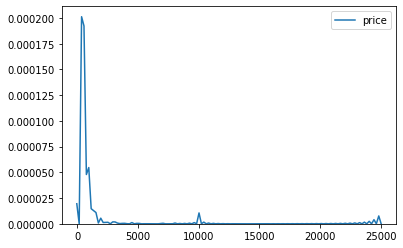

In [9]:
# density distribution for price
sns.kdeplot(listings['price']);

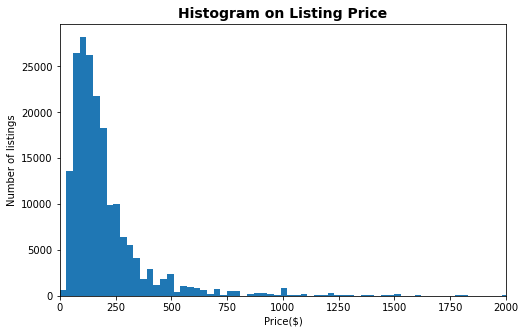

In [10]:
# Plot histogram for listing price
# Adjust the bean and set x limit
binsize = 30
bin_edges = np.arange(0, df['price'].max()+binsize, binsize)

plt.figure(figsize=[8, 5])
plt.hist(data = listings, x = 'price', bins = bin_edges)
plt.xlabel('Price($)')
plt.ylabel('Number of listings')
plt.title('Histogram on Listing Price', fontsize=14, fontweight='bold')
plt.xlim(0,2000) # set up a limit due to the outliers
plt.show()

**Observations:**
- id, host_id should be str
- drop columns not relevant to this analysis
- neighbourhood_group only contains null value; should be dropped
- Listing price of \\$25,000 seems to be unreasonably high. The mean and median listing price are \\$234 and \\$145 respectively while the max price is \\$25,000 per night. The outliers significantly skewed the average price. We'll use **median price** for our analysis.

#### San Francisco Crime Data

In [11]:
sf_crime.head()

Incident Datetime Incident Date Incident Time  Incident Year  \
0  2018/01/01 09:26:00 AM    2018/01/01         09:26           2018   
1  2018/01/01 02:30:00 AM    2018/01/01         02:30           2018   
2  2018/01/01 10:00:00 AM    2018/01/01         10:00           2018   
3  2018/01/01 10:03:00 AM    2018/01/01         10:03           2018   
4  2018/01/01 09:01:00 AM    2018/01/01         09:01           2018   

  Incident Day of Week         Report Datetime       Row ID  Incident ID  \
0               Monday  2018/01/01 09:27:00 AM  61893007041       618930   
1               Monday  2018/01/01 08:21:00 AM  61893105041       618931   
2               Monday  2018/01/01 10:20:00 AM  61893275000       618932   
3               Monday  2018/01/01 10:04:00 AM  61893565015       618935   
4               Monday  2018/01/01 09:39:00 AM  61893607041       618936   

   Incident Number   CAD Number  ... SF Find Neighborhoods  \
0        171052174  173641140.0  ...                  88.0   
1        180000768  180010668.0  ...                  90.0   
2        180000605  180010893.0  ...                  20.0   
3        180000887  180011579.0  ...                   NaN   
4        171052958  180011403.0  ...                 106.0   

  Current Police Districts Current Supervisor Districts  \
0                      2.0                          9.0   
1                      9.0                          1.0   
2                      4.0                         10.0   
3                      9.0                          1.0   
4                      6.0                          3.0   

   Analysis Neighborhoods HSOC Zones as of 2018-06-05 OWED Public Spaces  \
0                     1.0                         NaN                NaN   
1                     7.0                         NaN                NaN   
2                    36.0                         NaN                NaN   
3                    28.0                         NaN                NaN   
4                     6.0                         NaN                NaN   

  Central Market/Tenderloin Boundary Polygon - Updated  \
0                                                NaN     
1                                                NaN     
2                                                1.0     
3                                                NaN     
4                                                NaN     

  Parks Alliance CPSI (27+TL sites) ESNCAG - Boundary File  \
0                               NaN                    NaN   
1                               NaN                    NaN   
2                               NaN                    NaN   
3                               NaN                    NaN   
4                               NaN                    NaN   

   Areas of Vulnerability, 2016  
0                           2.0  
1                           2.0  
2                           2.0  
3                           1.0  
4                           2.0  

[5 rows x 36 columns]

In [12]:
# Check columns
sf_crime.columns

Index(['Incident Datetime', 'Incident Date', 'Incident Time', 'Incident Year',
       'Incident Day of Week', 'Report Datetime', 'Row ID', 'Incident ID',
       'Incident Number', 'CAD Number', 'Report Type Code',
       'Report Type Description', 'Filed Online', 'Incident Code',
       'Incident Category', 'Incident Subcategory', 'Incident Description',
       'Resolution', 'Intersection', 'CNN', 'Police District',
       'Analysis Neighborhood', 'Supervisor District', 'Latitude', 'Longitude',
       'point', 'SF Find Neighborhoods', 'Current Police Districts',
       'Current Supervisor Districts', 'Analysis Neighborhoods',
       'HSOC Zones as of 2018-06-05', 'OWED Public Spaces',
       'Central Market/Tenderloin Boundary Polygon - Updated',
       'Parks Alliance CPSI (27+TL sites)', 'ESNCAG - Boundary File',
       'Areas of Vulnerability, 2016'],
      dtype='object')

In [13]:
# Check neighbourhood data
sf_crime['Analysis Neighborhood'].unique()

array(['Bayview Hunters Point', 'Excelsior', 'Tenderloin',
       'Outer Mission', 'Chinatown', 'Financial District/South Beach',
       'Oceanview/Merced/Ingleside', 'South of Market', 'Lakeshore',
       'Western Addition', 'Sunset/Parkside', 'Haight Ashbury', 'Mission',
       'Lone Mountain/USF', 'Hayes Valley', 'Potrero Hill',
       'Treasure Island', 'Inner Richmond', 'West of Twin Peaks',
       'North Beach', 'Russian Hill', 'Noe Valley', 'Pacific Heights',
       'Mission Bay', 'Nob Hill', 'Outer Richmond', 'Japantown', nan,
       'Castro/Upper Market', 'Golden Gate Park', 'Visitacion Valley',
       'Inner Sunset', 'Seacliff', 'Bernal Heights', 'Presidio Heights',
       'Marina', 'Twin Peaks', 'Portola', 'Glen Park', 'Lincoln Park',
       'Presidio', 'McLaren Park'], dtype=object)

In [14]:
# Check for null values in neighbourhood 
sf_crime['Analysis Neighborhood'].isna().sum()

22312

**Observations:**
- We only need Incident ID, time, neighbourhood, Latitude and Longitude data for this analysis, other columns are not needed can be removed. Incident ID is the system generated identifier for incident reports and is unique for every incident. 
- Remove rows with null value in Analysis Neighborhood
- Neighbourood may be defined differently by organizations. Use **spartial join** to redefine neighbourhood to match the GeoJSON file of SF neighbourhoods defined by San Francisco Association of Realtors

### 4. Cleaning Data 
#### Combined Listing Data

1) Correct datatype

In [15]:
# Use astype(str) to convert datatype to str
listings.id = listings.id.astype(str)
listings.host_id = listings.host_id.astype(str)

# Use astype('category') to set data type to category
listings.room_type = listings.room_type.astype('category')
listings.neighbourhood =listings.neighbourhood.astype('category')

2) Drop unrelated columns

In [16]:
# Drop host_name and neighbourhood_group columns
listings.drop(['host_name','neighbourhood_group', 'last_review', 'minimum_nights', 'number_of_reviews', 'reviews_per_month'], axis=1, inplace=True)

# Rename neighbourhood column to not confused with redefined neighbourhood
listings.rename(columns = {'neighbourhood': 'nbr'}, inplace = True) 

# Examining Changes
listings.head(1)

id                                 name host_id               nbr  \
0  958  Bright, Modern Garden Unit - 1BR/1B    1169  Western Addition   

   latitude   longitude        room_type  price  \
0  37.76931 -122.433856  Entire home/apt    170   

   calculated_host_listings_count  availability_365        date  
0                               1                65  2019-02-01

####  San Francisco Crime Data
1) Remove unneeded columns

In [17]:
# Create new dataframe with only columns needed
df_crime = sf_crime[['Incident ID', 'Incident Datetime', 'Incident Year', 'Analysis Neighborhood', 'Latitude', 'Longitude']].copy()

# Test results
df_crime.head(5)

Incident ID       Incident Datetime  Incident Year  Analysis Neighborhood  \
0       618930  2018/01/01 09:26:00 AM           2018  Bayview Hunters Point   
1       618931  2018/01/01 02:30:00 AM           2018              Excelsior   
2       618932  2018/01/01 10:00:00 AM           2018             Tenderloin   
3       618935  2018/01/01 10:03:00 AM           2018          Outer Mission   
4       618936  2018/01/01 09:01:00 AM           2018              Chinatown   

    Latitude   Longitude  
0  37.721716 -122.395944  
1  37.722000 -122.433606  
2  37.783370 -122.420832  
3  37.724683 -122.434798  
4  37.796698 -122.401294

2) Remove rows with null in Analysis Neighborhoods

In [18]:
# Filter for non null values in Analysis Neighborhood
df_crime = df_crime[df_crime['Analysis Neighborhood'].notnull()]

# Test results
df_crime.isnull().sum()

Incident ID              0
Incident Datetime        0
Incident Year            0
Analysis Neighborhood    0
Latitude                 0
Longitude                0
dtype: int64

3) Redefine neighbourhood 

Use the geojson file from San Francisco Association of Realtors to redefine neighbourhoods.

In [19]:
# Load realtor Neighborhoods geojson and rename column 
nbr_geo = gpd.read_file('Realtor Neighborhoods.geojson')
nbr_geo.rename(columns = {'nbrhood': 'neighbourhood'}, inplace = True) 
nbr_geo.head(5)

neighbourhood  nid                    sfar_distr  \
0    Alamo Square   6e    District 6 - Central North   
1      Anza Vista   6a    District 6 - Central North   
2  Balboa Terrace   4a  District 4 - Twin Peaks West   
3         Bayview  10a       District 10 - Southeast   
4  Bernal Heights   9a     District 9 - Central East   

                                            geometry  
0  MULTIPOLYGON (((-122.42948 37.77510, -122.4310...  
1  MULTIPOLYGON (((-122.44746 37.77986, -122.4473...  
2  MULTIPOLYGON (((-122.46451 37.73221, -122.4650...  
3  MULTIPOLYGON (((-122.38759 37.75026, -122.3874...  
4  MULTIPOLYGON (((-122.40375 37.74919, -122.4046...

In [20]:
# Transform Longitude and Latitude into a list of shapely.Point objects and set it as a geometry
# Reference - https://geopandas.readthedocs.io/en/latest/gallery/create_geopandas_from_pandas.html
crime_geo = gpd.GeoDataFrame(df_crime, geometry=gpd.points_from_xy(df_crime.Longitude, df_crime.Latitude))
crime_geo.head(5)

Incident ID       Incident Datetime  Incident Year  Analysis Neighborhood  \
0       618930  2018/01/01 09:26:00 AM           2018  Bayview Hunters Point   
1       618931  2018/01/01 02:30:00 AM           2018              Excelsior   
2       618932  2018/01/01 10:00:00 AM           2018             Tenderloin   
3       618935  2018/01/01 10:03:00 AM           2018          Outer Mission   
4       618936  2018/01/01 09:01:00 AM           2018              Chinatown   

    Latitude   Longitude                     geometry  
0  37.721716 -122.395944  POINT (-122.39594 37.72172)  
1  37.722000 -122.433606  POINT (-122.43361 37.72200)  
2  37.783370 -122.420832  POINT (-122.42083 37.78337)  
3  37.724683 -122.434798  POINT (-122.43480 37.72468)  
4  37.796698 -122.401294  POINT (-122.40129 37.79670)

In [21]:
# Use spatial join to match crime data to realtor Neighborhoods geojson
df_crime_geo = gpd.sjoin(nbr_geo, crime_geo, how='left')

# Investigate the result
print("We located {} incidents.".format(len(df_crime)))
print("{} of the incidents were located in {} different neighbourhoods).".format(
    len(df_crime_geo), len(df_crime_geo.neighbourhood.unique())))

df_crime_geo.head(5)

C:\Users\Shen\Anaconda3\lib\site-packages\geopandas\tools\sjoin.py:61: UserWarning: CRS of frames being joined does not match!({'init': 'epsg:4326'} != None)
  "(%s != %s)" % (left_df.crs, right_df.crs)


We located 416772 incidents.
415280 of the incidents were located in 92 different neighbourhoods).


neighbourhood nid                  sfar_distr  \
0  Alamo Square  6e  District 6 - Central North   
0  Alamo Square  6e  District 6 - Central North   
0  Alamo Square  6e  District 6 - Central North   
0  Alamo Square  6e  District 6 - Central North   
0  Alamo Square  6e  District 6 - Central North   

                                            geometry  index_right  \
0  MULTIPOLYGON (((-122.42948 37.77510, -122.4310...         6245   
0  MULTIPOLYGON (((-122.42948 37.77510, -122.4310...        96772   
0  MULTIPOLYGON (((-122.42948 37.77510, -122.4310...         5824   
0  MULTIPOLYGON (((-122.42948 37.77510, -122.4310...       234713   
0  MULTIPOLYGON (((-122.42948 37.77510, -122.4310...       418481   

   Incident ID       Incident Datetime  Incident Year Analysis Neighborhood  \
0       627007  2018/01/22 04:20:00 PM           2018      Western Addition   
0       966718  2020/10/04 05:15:00 PM           2020      Western Addition   
0       626626  2018/01/20 07:00:00 PM           2018      Western Addition   
0       799094  2019/05/07 10:00:00 PM           2019      Western Addition   
0       991121  2020/12/29 12:01:00 PM           2020      Western Addition   

   Latitude   Longitude  
0  37.77749 -122.433219  
0  37.77749 -122.433219  
0  37.77749 -122.433219  
0  37.77749 -122.433219  
0  37.77749 -122.433219

In [219]:
# Export crime_data for Tableau dashboards
#crime_data = pd.DataFrame(df_crime_geo.drop(columns='geometry'))
#crime_data.to_csv('crime_data.csv', index = False, header=True)

<a id='exploration'></a>
## IV. Data Exploration & Visualization

#### 1.  Number of listings

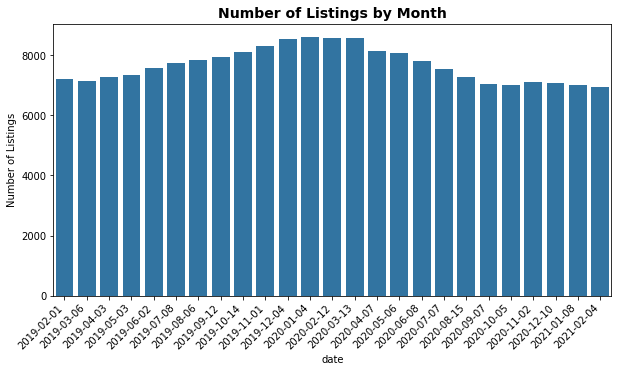

In [22]:
plt.figure(figsize=(10,5))
base_color = sns.color_palette()[0]
count = sns.countplot(data=listings, x='date', color=base_color)
count.set_xticklabels(count.get_xticklabels(), rotation=45, horizontalalignment='right')
plt.ylabel('Number of Listings')
plt.title('Number of Listings by Month', fontsize=14, fontweight='bold');

#### 2.  Price

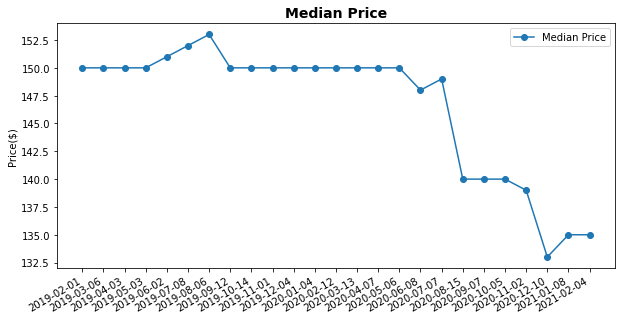

In [23]:
#Plot mean and average price
date = listings.date.unique()
y1 = listings.groupby('date').price.median()
#y2 = listings.groupby('date').price.mean()

fig = plt.figure(figsize=[10, 5])
plt.plot(date, y1, marker='o', label = 'Median Price')
#plt.plot(date, y2, marker='o', color='green', label = 'Price Average')
plt.ylabel('Price($)')
plt.title('Median Price', fontsize=14, fontweight='bold')
fig.autofmt_xdate()
plt.legend();

#### 3. Neighbourhood

Let's take a close look at neighbourhood. We'll use Feb 2021 listings. Neighbourood may be defined differently by different organizations. Use **spartial join** to redefine neighbourhood to match the GeoJSON file of SF neighbourhoods defined by San Francisco Association of Realtors

In [24]:
# Load Feb 2021 data
df2021_02 = pd.read_csv('2021-02-04.csv')

# Drop unneeded columns
df2021_02.drop(['host_name','neighbourhood_group', 'last_review', 'minimum_nights', 'number_of_reviews', 'reviews_per_month', 'calculated_host_listings_count'], axis=1, inplace=True)

# Rename neighbourhood column to not confused with redefined neighbourhood
df2021_02.rename(columns = {'neighbourhood': 'nbr'}, inplace = True) 

# Transform Longitude and Latitude into a list of shapely.Point objects and set it as a geometry
df2021_02_geo = gpd.GeoDataFrame(df2021_02, geometry=gpd.points_from_xy(df2021_02.longitude, df2021_02.latitude))

# Use spatial join to match Feb 2021 listings data to match realtor Neighborhoods 
df = gpd.sjoin(nbr_geo, df2021_02_geo, how='left')

# Investigate the result
print("We located {} listings.".format(len(df2021_02)))
print("{} of the listings were located in {} different neighbourhoods).".format(
    len(df), len(df.neighbourhood.unique())))

df.head(5)

C:\Users\Shen\Anaconda3\lib\site-packages\geopandas\tools\sjoin.py:61: UserWarning: CRS of frames being joined does not match!({'init': 'epsg:4326'} != None)
  "(%s != %s)" % (left_df.crs, right_df.crs)


We located 6931 listings.
6930 of the listings were located in 92 different neighbourhoods).


neighbourhood nid                  sfar_distr  \
0  Alamo Square  6e  District 6 - Central North   
0  Alamo Square  6e  District 6 - Central North   
0  Alamo Square  6e  District 6 - Central North   
0  Alamo Square  6e  District 6 - Central North   
0  Alamo Square  6e  District 6 - Central North   

                                            geometry  index_right          id  \
0  MULTIPOLYGON (((-122.42948 37.77510, -122.4310...       3351.0  24329618.0   
0  MULTIPOLYGON (((-122.42948 37.77510, -122.4310...       2181.0  15732801.0   
0  MULTIPOLYGON (((-122.42948 37.77510, -122.4310...       2125.0  15269286.0   
0  MULTIPOLYGON (((-122.42948 37.77510, -122.4310...       5947.0  42361981.0   
0  MULTIPOLYGON (((-122.42948 37.77510, -122.4310...       5361.0  39507387.0   

                                            name     host_id  \
0  ROAM SF: Unique Living Experience - Alamo Sq.  61981957.0   
0           Comfortable 2 BR APT in Alamo Square     38836.0   
0  Comfortable, private, garden level apartment.  33460481.0   
0                        2 Beds & 1 Ba, Alamo Sq  48972017.0   
0                         Alamo Square Victorian    339635.0   

                nbr  latitude  longitude        room_type  price  \
0  Western Addition  37.77869 -122.43346     Private room  200.0   
0  Western Addition  37.77884 -122.43386  Entire home/apt  153.0   
0  Western Addition  37.77899 -122.43570  Entire home/apt  125.0   
0  Western Addition  37.77736 -122.43735  Entire home/apt  300.0   
0  Western Addition  37.77778 -122.43704     Private room  100.0   

   availability_365  
0              89.0  
0             249.0  
0             269.0  
0             365.0  
0              89.0

In [218]:
# Export Listing data for Tableau 
#listing_data = pd.DataFrame(df.drop(columns='geometry'))
#listing_data.to_csv('listing_data.csv', index = False, header=True)

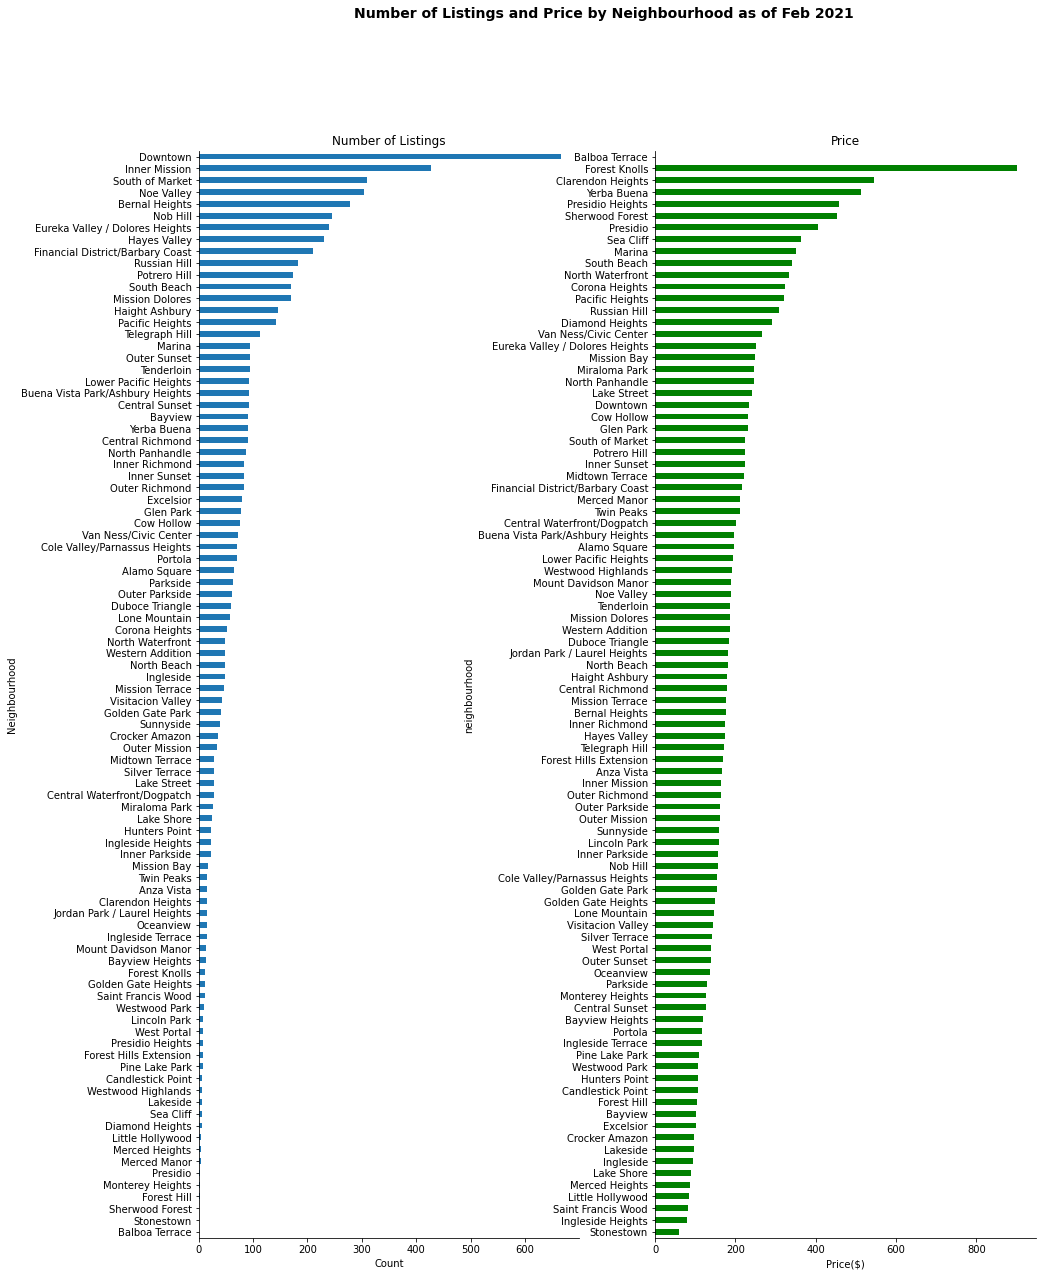

In [25]:
fig = plt.figure(figsize = [15, 20])

# left plot: Number of listings
plt.subplot(1, 2, 1)
ax1 = df.neighbourhood.value_counts().sort_values().plot(kind = 'barh')
plt.xlabel('Count')
plt.ylabel('Neighbourhood')
plt.title('Number of Listings')

# right plot: price
plt.subplot(1, 2, 2)
ax2 = df.groupby('neighbourhood').price.mean().sort_values().plot(kind='barh', color='green')
plt.xlabel('Price($)')
plt.title('Price')
fig.suptitle('Number of Listings and Price by Neighbourhood as of Feb 2021', fontsize=14, fontweight='bold')

# Remove borders
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)
plt.show();

In [26]:
# geo dataframe & plot dataframe
sf_geometry = nbr_geo.set_index('neighbourhood')
plot = df.neighbourhood.value_counts()

# Create a base map
m1 = folium.Map(location=[37.7749,-122.4194], tiles='cartodbpositron', zoom_start=12)

# Add a choropleth map to the base map
choropleth = folium.Choropleth(geo_data=sf_geometry.__geo_interface__, 
           data=plot, 
           key_on="feature.id", 
           fill_color='YlGnBu', 
           legend_name='Number of Listings Feb 2021',
          ).add_to(m1)

# Add label layer
folium.map.CustomPane('labels').add_to(m1)
folium.TileLayer('CartoDBPositronOnlyLabels',pane='labels').add_to(m1)

# Display the map
m1

#GeoJsonTooltip(....).add_to(choropleth.geojson)

In [27]:
# price data
median_price = df.groupby('nbr').price.median()
sf_geo = gpd.read_file('neighbourhoods.geojson')
sf_nbr =sf_geo.set_index('neighbourhood')

# Create a base map
m2 = folium.Map(location=[37.7749,-122.4194], tiles='cartodbpositron', zoom_start=12)

# Add a choropleth map to the base map
choropleth = folium.Choropleth(geo_data=sf_nbr.__geo_interface__, 
           data=median_price, 
           key_on="feature.id", 
           fill_color='YlGn', 
           legend_name='Median Listing Price as of Feb 2021',
          ).add_to(m2)

# Add label layer
folium.map.CustomPane('labels').add_to(m2)
folium.TileLayer('CartoDBPositronOnlyLabels',pane='labels').add_to(m2)

# Display the map
m2

#### 4. Room Type

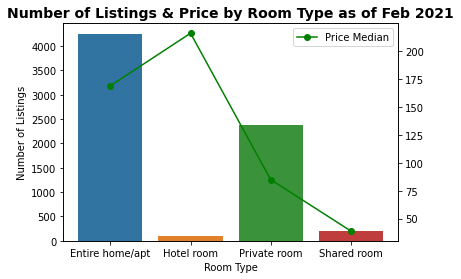

In [28]:
fig, ax1 = plt.subplots(figsize=(6,4))

ax1 = sns.countplot(data=df2021_02, x='room_type', order=['Entire home/apt', 'Hotel room', 'Private room', 'Shared room'])
ax1.set_xlabel('Room Type')
ax1.set_ylabel('Number of Listings')

ax2 = ax1.twinx()
#ax2.plot(df.groupby('room_type').price.mean(), color = 'black', marker='o', label='Price Avg.') 
ax2.plot(df2021_02.groupby('room_type').price.median(), color = 'green', marker='o', label = 'Price Median')
plt.title('Number of Listings & Price by Room Type as of Feb 2021', fontsize=14, fontweight='bold')
plt.legend()
plt.show()

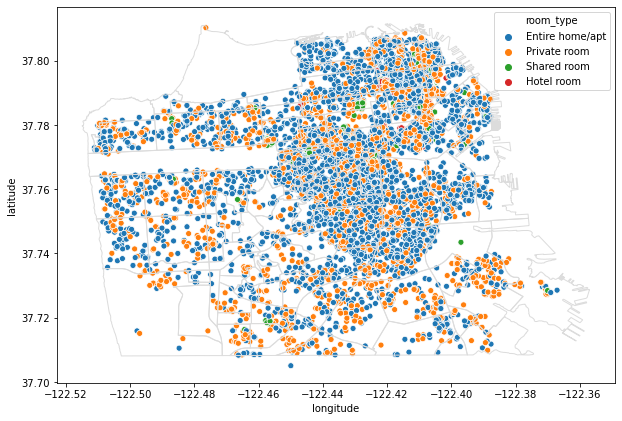

In [29]:
fig, ax = plt.subplots(figsize=(10,10))
nbr_geo.plot(ax=ax, color='none', edgecolor='gainsboro', zorder=3)
sns.scatterplot(df2021_02.longitude,df2021_02.latitude,hue=df2021_02.room_type, ax=ax);

#### 5. San Francisco Crime Data


In [37]:
# geo dataframe & plot dataframe
sf_geometry = nbr_geo.set_index('neighbourhood')
crime2020 = df_crime_geo[df_crime_geo['Incident Year']==2020]
val_counts = crime2020['neighbourhood'].value_counts()

# Create a base map
m3 = folium.Map(location=[37.7749,-122.4194], tiles='cartodbpositron', zoom_start=12)

# Add a choropleth map to the base map
choropleth = folium.Choropleth(geo_data=sf_geometry.__geo_interface__, 
           data=val_counts, 
           key_on='feature.id',
           columns = ['neighbourhood','counts'],                    
           fill_color='YlOrRd', 
           legend_name='Number of Crimes in San Francisco, by Neighborhood 2020',
          ).add_to(m3)

# Add label layer
folium.map.CustomPane('labels').add_to(m3)
folium.TileLayer('CartoDBPositronOnlyLabels',pane='labels').add_to(m3)
#folium.GeoJsonTooltip(fields=['feature.properties.counts']).add_to(choropleth.geojson)

# Display the map
m3

#### 6. Popular words used in listings

In [38]:
df_detail = pd.read_csv('listingsFeb2021.csv')
df_detail.head(3)

id                        listing_url       scrape_id last_scraped  \
0   958   https://www.airbnb.com/rooms/958  20210108081038   2021-01-10   
1  5858  https://www.airbnb.com/rooms/5858  20210108081038   2021-01-10   
2  7918  https://www.airbnb.com/rooms/7918  20210108081038   2021-01-10   

                                         name  \
0       Bright, Modern Garden Unit - 1BR/1BTH   
1                          Creative Sanctuary   
2  A Friendly Room - UCSF/USF - San Francisco   

                                         description  \
0  Due to city restrictions, out of state visitor...   
1  <b>The space</b><br />We live in a large Victo...   
2  Nice and good public transportation.  7 minute...   

                               neighborhood_overview  \
0  Quiet cul de sac in friendly neighborhood<br /...   
1  I love how our neighborhood feels quiet but is...   
2  Shopping old town, restaurants, McDonald, Whol...   

                                         picture_url  host_id  \
0  https://a0.muscache.com/pictures/b7c2a199-4c17...     1169   
1  https://a0.muscache.com/pictures/17714/3a7aea1...     8904   
2  https://a0.muscache.com/pictures/26356/8030652...    21994   

                                  host_url  ... review_scores_communication  \
0   https://www.airbnb.com/users/show/1169  ...                        10.0   
1   https://www.airbnb.com/users/show/8904  ...                        10.0   
2  https://www.airbnb.com/users/show/21994  ...                         9.0   

  review_scores_location review_scores_value      license instant_bookable  \
0                   10.0                10.0  STR-0001256                f   
1                   10.0                 9.0          NaN                f   
2                    9.0                 8.0          NaN                f   

  calculated_host_listings_count calculated_host_listings_count_entire_homes  \
0                              1                                           1   
1                              1                                           1   
2                              8                                           0   

  calculated_host_listings_count_private_rooms  \
0                                            0   
1                                            0   
2                                            8   

  calculated_host_listings_count_shared_rooms reviews_per_month  
0                                           0              1.95  
1                                           0              0.78  
2                                           0              0.14  

[3 rows x 74 columns]

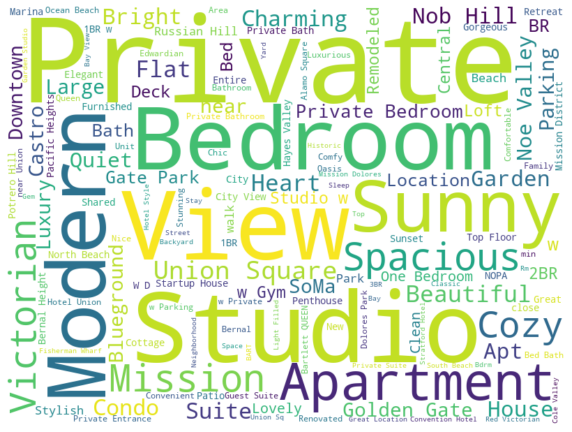

In [389]:
# wordcloud image
plt.figure(figsize = (10,10))
text = ' '.join(name for name in df_detail.name)

# Create stopword list:
stopwords = set(STOPWORDS)
stopwords.update(['SF', 'san', 'francisco', 'Room', 'home'])
#'Room', 'House', 'Studio', 'bedroom', 'home'

# Generate a word cloud image
wordcloud = WordCloud(stopwords=stopwords, background_color='white', width=800, height=600,min_font_size=10).generate(text)

# Display the generated image:
# the matplotlib way:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

<a id='insights'></a>
## V. Insights
### 1. Trend in number of listings and median price 2019 - 2020.


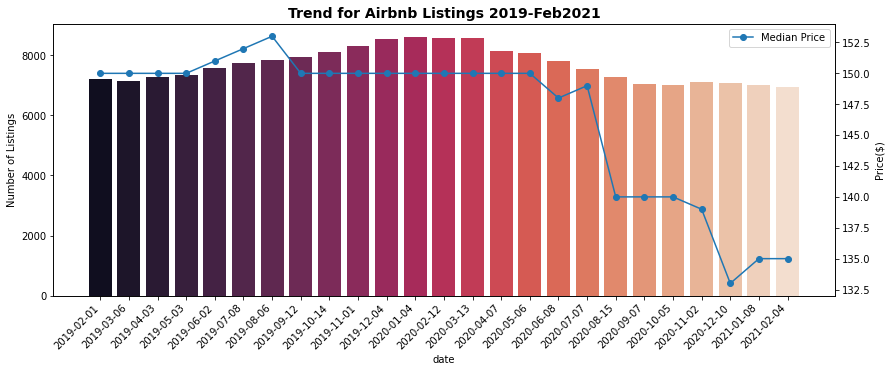

In [397]:
#Create combo chart
fig, ax1 = plt.subplots(figsize=(14,5))
#base_color = sns.color_palette()[0]

# bar plot 
ax1 = sns.countplot(data=listings, x='date', palette='rocket')
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, horizontalalignment='right')
ax1.set_ylabel('Number of Listings')

#specify we want to share the same x-axis
ax2 = ax1.twinx()

#line plot 
date = listings.date.unique()
y1 = listings.groupby('date').price.median()
#y2 = listings.groupby('date').price.mean()

ax2.plot(date, y1, marker='o', label = 'Median Price')
#ax2.plot(date, y2, marker='o', color='green', label = 'Price Average')
plt.ylabel('Price($)')

plt.title('Trend for Airbnb Listings 2019-Feb2021', fontsize=14, fontweight='bold')
plt.legend()
plt.show()
#plt.savefig('trend.png')

### Insights:

>From the graph above, we can see that the number of listings on Airbnb increased steadily during 2019 then decreased during 2020. The median listing price was relatively stable during 2019 and decreased after that. This is probably due to COVID-19 which had destructive impact on the travel and tourism industry. 

- - -

### 2. What is the most common listing type? How should I list my new vacation house to maximize my profit? How is Airbnb compared to Traditional Renting?
According to Airbnb, hosts can list **entire homes/apartments, private** or **shared rooms**.

**1) Most common room type**

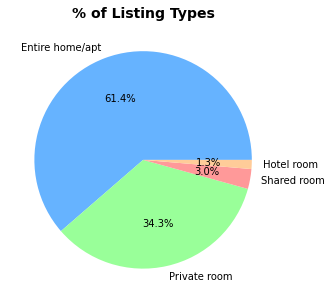

In [288]:
# % of room type pie chart 
values = df.room_type.value_counts(normalize=True).to_list()
labels = df.room_type.value_counts(normalize=True).index.to_list()
colors = ['#66b3ff','#99ff99','#ff9999','#ffcc99']

fig, ax = plt.subplots(figsize=(5,5))
ax.pie(values, labels=labels, autopct='%1.1f%%', colors=colors)
plt.title('% of Listing Types', fontsize=14, fontweight='bold')
plt.show()

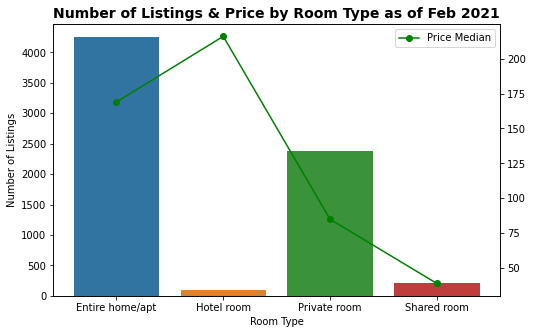

In [300]:
# Combo chart: number of listing & median price 
fig, ax1 = plt.subplots(figsize=(8,5))

ax1 = sns.countplot(data=df2021_02, x='room_type', order=['Entire home/apt', 'Hotel room', 'Private room', 'Shared room'])
ax1.set_xlabel('Room Type')
ax1.set_ylabel('Number of Listings')

ax2 = ax1.twinx()
#ax2.plot(df.groupby('room_type').price.mean(), color = 'black', marker='o', label='Price Avg.') 
ax2.plot(df2021_02.groupby('room_type').price.median(), color = 'green', marker='o', label = 'Price Median')

plt.title('Number of Listings & Price by Room Type as of Feb 2021',fontsize=14, fontweight='bold')
plt.legend()
plt.show()

According to Airbnb, listings are categorized into the following room types:
- **Entire place**: Guests have the whole place to themselves. This usually includes a bedroom, a bathroom, and a kitchen.
- **Private room**: Guests have their own private room for sleeping. Other areas could be shared.
- **Shared room**: Guests sleep in a bedroom or a common area that could be shared with others.
- **Hotel room**: regular hotel rooms hosted by professional hospitality businesses 

| Room Type | Percentage | Median Price per Night | 
| --- | --- | --- |
| Entire home/apt | 61.4% | 169 |  
| Private room | 34.3% | 85 | 
| Shared room | 3% | 39 |  
| Hotel room | 1.3% | 216 |

Entire homes/apt are best for people seeking a home away from home with complete privacy. While entire house is the most popular room type, private room is also very popular because it's much more affordable, and some people enjoy social interaction with others while traveling and also hosts knows the area well and has great advice of things to see. The median price for entire home is \\$169 per night while the median price for private room is only \\$85 per night, almost half of the price of entire home. San Francisco is one of the wealthiest and most expensive cities in America. The cost for accommodation for traveling in San Francisco can be quite expensive. Private room is much cheaper than hotels and entire house, making travel afforable for many people while expand income for homeowners. 

### Insights:
>- In San Francisco more than 60% of listings are Entire home/apt, with about 34% being listed as Private rooms. The rest are Shared rooms (3%) and Hotel room (1.3%). Given the small number of Shared rooms and Hotel rooms we will ignore these two and focus on the most common two listing options, Entire home/apt and Private room.  Now let's move on to the question about how to decide room type as a host.
>- The median price for entire home is \\$169 per night while the median price for private room is only \\$85 per night, almost half of the price of entire home. 

***

**2) How should I list my new vacation house, by entire house or by private room to maximize my profit?**

By filtering the dataset,we can easily acquire median listing price per night for entire house with different number of bedrooms and also median price for 1 private room.

In [309]:
# clean price data 
df_detail.price = df_detail.price.str.replace(',', '').str.replace('$', '').astype(float)

# Filter entire home price data based on bedrooms
br2 = df_detail.query('room_type == "Entire home/apt" & bedrooms == 2')
br3 = df_detail.query('room_type == "Entire home/apt" & bedrooms == 3')
br4 = df_detail.query('room_type == "Entire home/apt" & bedrooms == 4')

# Filter private room price data
br1 = df_detail.query('room_type == "Private room"')

print('Median listing price for entire house with 2 bedrooms: ' + str(br2.price.median()))
print('Median listing price for entire house with 3 bedrooms: ' + str(br3.price.median()))
print('Median listing price for entire house with 4 bedrooms: ' + str(br4.price.median()))
print('Median listing price for 1 private room ' + str(br1.price.median()))

Median listing price for entire house with 2 bedrooms: 200.0
Median listing price for entire house with 3 bedrooms: 300.0
Median listing price for entire house with 4 bedrooms: 457.0
Median listing price for 1 private room 85.0


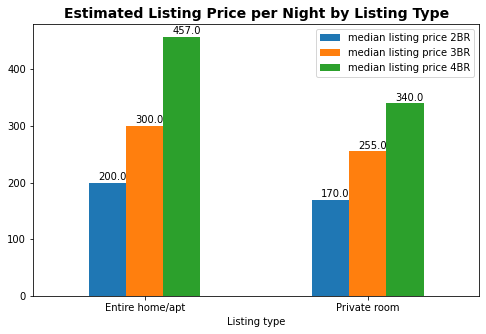

In [387]:
# Create dataframe with price data
d = {'room type': ['Entire home/apt', 'Private room'], 
     'median listing price 2BR': [br2.price.median(), 2*(br1.price.median())],
     'median listing price 3BR': [br3.price.median(), 3*(br1.price.median())],
     'median listing price 4BR': [br4.price.median(), 4*(br1.price.median())]}

median_price  = pd.DataFrame(data=d)

# Display data
display(HTML(median_price.to_html()))

# Plot bar chart 
estimate = median_price.plot(x='room type', kind='bar', figsize=(8,5))
estimate.set_xticklabels(estimate.get_xticklabels(), rotation=0, horizontalalignment='center')
estimate.set_xlabel('Listing type')
plt.title('Estimated Listing Price per Night by Listing Type', fontsize=14, fontweight='bold')

# set individual bar lables using above list
for i in estimate.patches:
    # get_x pulls left or right; get_height pushes up or down
    estimate.text(i.get_x()+.04, i.get_height()+5, \
            str(round((i.get_height()), 2)), rotation=0)

plt.show()
#plt.savefig('how to list.png')

**Methodology and Assumptions:**
- By filtering the dataset,we can easily acquire median listing price per night for entire house with different number of bedrooms.
- Estimated Price per night (listing separately) = Median Listing Price Private Room * Number of Bedrooms
- Median listing price per night for 1 private room 85.

Assume all rooms in the house can be rented out at the same time, by multiplying the number of bedrooms with the median listing price for private room, we can get a approx value for income by listing rooms separately. This value can be compared with income of listing entire house and can be a good estimate when deciding listing type. For example, the daily price for two private rooms is \\$170 as compared to \\$200 for a 2-bedroom home as en entire place. Listing entire place is more profitable.

| Room Type | Median Listing Price 2BR | Median Listing Price 3BR | Median Listing Price 4BR |
| --- | --- | --- | --- |
| Entire home/apt | 200 | 300 | 457 |
| Private room | 170 | 255 | 340 |

### Insights:
>Renting the entire home/apt makes more money than listing rooms separately.

>Advantages of listing entire home/apt:
- Higher return 
- Easier to manage than listing each room separately
- More cleaning fee as an entire house 
- Attractive to many travelers: more privacy, vacationers who prefer more privacy and those traveling with families and friends
- Hard to list all rooms at the same time in reality for separate listing
***

**3) Airbnb vs. Traditional Renting**

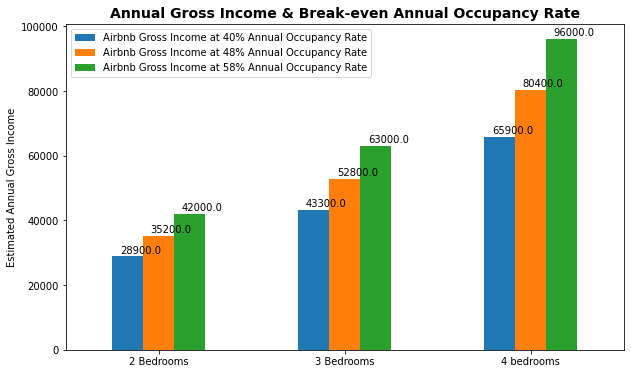

In [393]:
# Create a dataframe for data
data = {'Number of Bedrooms': [2, 3, 4],
        'Median Monthly Rent': [3500, 4400, 5495],
        'Airbnb Median Daily Rate': [200, 300, 457]}

gross_income = pd.DataFrame(data, columns = ['Number of Bedrooms', 'Median Monthly Rent', 'Airbnb Median Daily Rate'])
gross_income['Renting Annual Gross Income'] = gross_income['Median Monthly Rent']*12
gross_income['Break-even Annual Occupancy Rate'] = gross_income['Renting Annual Gross Income']/gross_income['Airbnb Median Daily Rate']/365

gross_income['Airbnb Gross Income at 40% Annual Occupancy Rate'] = round(gross_income['Airbnb Median Daily Rate']*0.3953*365, -2)
gross_income['Airbnb Gross Income at 48% Annual Occupancy Rate'] = round(gross_income['Airbnb Median Daily Rate']*0.4822*365, -2)
gross_income['Airbnb Gross Income at 58% Annual Occupancy Rate'] = round(gross_income['Airbnb Median Daily Rate']*0.5753*365, -2)

# Display data
display(HTML(gross_income.to_html()))

# Plot data
ax = gross_income[['Airbnb Gross Income at 40% Annual Occupancy Rate', 
                   'Airbnb Gross Income at 48% Annual Occupancy Rate', 
                   'Airbnb Gross Income at 58% Annual Occupancy Rate']].plot(kind='bar',figsize=(10,6))
ax.set_title('Annual Gross Income & Break-even Annual Occupancy Rate', fontsize=14, fontweight='bold')
ax.set_ylabel('Estimated Annual Gross Income')
ax.set_xticklabels(['2 Bedrooms', '3 Bedrooms', '4 bedrooms'], rotation=0)
# set individual bar lables using above list
for i in ax.patches:
    # get_x pulls left or right; get_height pushes up or down
    ax.text(i.get_x()+.04, i.get_height()+1000, \
            str(round((i.get_height()), 2)), rotation=0)
#plt.savefig('break-even.png')

**Methodology and Assumptions:**
- Assume the tenant signed a 12 month lease.
- The annual occupancy rate is the number of days rented out of a year. 
- We can calculate and compare estimated **annual gross income** for Airbnb and traditional renting by the following equations:

 >- Estimated Annual Gross Income - Airbnb  = Annual Occupancy Rate  * 365 * Median Daily Price  
 >- Estimated Annual Gross Income - Traditional Renting = Median Monthly Rent * 12

- The break-even point is the annual occupancy rate when the two options yield the same gross income. When the rate is higher than the break-even point, Airbnb makes the most money. When occupancy rate is lower than the break-even point, traditional renting is more profitble. 

For example, the median monthly rent for 2 bedrooms is \\$3,500 per month. That represents $42,000 gross income if the tenant signed a 12 month lease. The median daily rate on Airbnb is \\$200 and the break-even occupancy rate is 58%. If I rent the same property on Airbnb for \\$200 per night at annual occupancy rate of 58%, I can earn \\$50,000 in gross revenue from the rental, which is \\$8,000 more than the rents earned from long-term lease. 

### Insights:
>- A solidly booked Airbnb listing can be more profitable than renting the same property in the traditional way. 
>- When the annual occupancy rate is higher than the break-even point, Airbnb makes more money. When occupancy rate is lower than the break-even point, traditional renting is more profitble. 
>- The more the number of bedrooms, the lower the break-even rate. 
 - For 2-bedroom house, the break-even rate is 58%.
 - For 3-bedroom house, the break-even rate is 48%
 - For 4-bedroom house, the break-even rate is 40%

**Note:**  
1. The median monthly rent for different number of bedrooms was accessed from [Zumper](https://www.zumper.com/rent-research/san-francisco-ca) on Mar 4, 2021.
2. We only consider gross income in this case due to the availability of data. However, in reality the operating costs will likely be higher than for a traditional rental property, e.g., cleaning fee, furnitures, appliances, amenities, decor, etc.
3. It’s unlikely to keep an Airbnb listing booked nearly every night. There'll be many vacant dates.
***

### 3. What's the percentage of single listing hosts? How do they list their property?

San Francisco has one of the highest costs of living in the United States. Offering flexibility and added revenue stream, hosting Airbnb listings can be a tempting opportunity for homeowners. They can make money off space not using by listing a guest room as a private room or by listing the entire vacation house. It's a good way to get the most from home buying investment. 

Based on my research and running the numbers, I've decided to rent my future vacation house on Airbnb by entire house in a single listing. Now I'm interested to know the percentage of single listing hosts and how they list their home. 

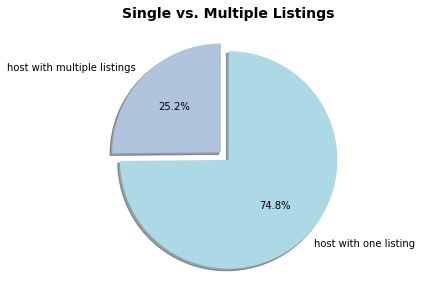

In [46]:
# Data 
one = df.host_id.value_counts()[lambda x: x == 1].size 
multiple = df.host_id.value_counts()[lambda x: x > 1].size 
percentage=[one, multiple]
labels = 'host with one listing', 'host with multiple listings'
colors = ['lightblue','lightsteelblue']

# Plot pie chart
plt.figure(figsize=[7,5])
explode = (0, 0.1) 
plt.pie(percentage, labels = labels, explode=explode, autopct='%1.1f%%',shadow=True, startangle = 90,counterclock = False, colors=colors)
plt.title('Single vs. Multiple Listings', fontsize=14, fontweight='bold')
plt.show()

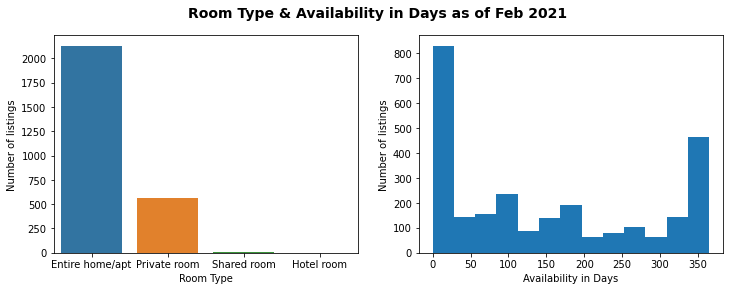

In [32]:
# list of host id for hosts with one listing
single_listing_host = df.host_id.value_counts()[lambda x: x == 1].index.tolist()

# filter dataframe for single listing
df_single = df.loc[df['host_id'].isin(single_listing_host)]

fig = plt.figure(figsize = [12, 4])   

# left plot
plt.subplot(1, 2, 1)
sns.countplot(data=df_single, x='room_type')
plt.xlabel('Room Type')
plt.ylabel('Number of listings')

# right plot
plt.subplot(1, 2, 2)
plt.hist(data = df_single, x = 'availability_365', bins = 13)
plt.xlabel('Availability in Days')
plt.ylabel('Number of listings')

fig.suptitle('Room Type & Availability in Days as of Feb 2021', fontsize=14, fontweight='bold')
plt.show()

### Insights:
>Nearly 75% of the hosts have one listing and entire home/apt is the major listing type. The availability in days shows how many days in a year the host make the house/room available on Airbnb. The graph shows that short renting within 25 days is the most common type, followed by renting all year round, with the rest spreaded out. This confirms our previous thought that many homeowners in San Francisco use their own home for listing to earn extra income or use another property they owned such as vacation house for listing. 

***

### 4. Which neighbourhood should I buy?

In [103]:
# geo dataframe & plot dataframe
sf_geometry = nbr_geo.set_index('neighbourhood')
crime2020 = df_crime_geo[df_crime_geo['Incident Year']==2020]
val_counts = crime2020['neighbourhood'].value_counts()

# Create a base map
m3 = folium.Map(location=[37.7749,-122.4194], tiles='cartodbpositron', zoom_start=12)

# Add a choropleth map to the base map
choropleth = folium.Choropleth(geo_data=sf_geometry.__geo_interface__, 
           data=val_counts, 
           key_on='feature.id',
           columns = ['neighbourhood','counts'],                    
           fill_color='YlOrRd', 
           legend_name='Number of Crimes in San Francisco, by Neighborhood 2020',
          ).add_to(m3)

# Add label layer
folium.map.CustomPane('labels').add_to(m3)
folium.TileLayer('CartoDBPositronOnlyLabels',pane='labels').add_to(m3)
#folium.GeoJsonTooltip(fields=['feature.properties.counts']).add_to(choropleth.geojson)

# Display the map
m3

In [48]:
# Load median house price data
house_price = pd.read_csv('SF house median price.csv')

# Filter dataframe for entire home/apt
df_eh = df.query('room_type == "Entire home/apt"')

# Number of listing entire house by neighbourhood
counts = pd.DataFrame(df_eh.neighbourhood.value_counts()).reset_index()
counts.columns = ['neighbourhood', 'Number of Listings']

# Median listing price by neighbourhood for entire house
median_listing = pd.DataFrame(df_eh.groupby('neighbourhood').price.median()).reset_index()
median_listing.columns = ['neighbourhood', 'Median Listing Price']

# Number of crimes incidents by neighbourhood 2020
crime2020 = df_crime_geo[df_crime_geo['Incident Year']==2020]
incidents_counts = pd.DataFrame(crime2020['neighbourhood'].value_counts()).reset_index()
incidents_counts.columns = ['neighbourhood', 'Number of Incidents']

# Median house price by neighbourhood 2020
median_house_price = house_price[['neighbourhood','Median House Sales Price']].copy()

# Combine thee dataframes
merged_df = pd.merge(counts, median_listing, on='neighbourhood')
df_nbhd = pd.merge(merged_df, incidents_counts, on='neighbourhood')
combined = pd.merge(df_nbhd, median_house_price, on='neighbourhood', how='left')

# Gross income assume the house is occupied 250 days out of the year
combined['Gross Income'] = combined['Median Listing Price']*250
combined['Rate of Return'] = combined['Gross Income']/combined['Median House Sales Price']
#combined['Rate of Return'] = combined['Rate of Return'].map(lambda n: '{:,.2%}'.format(n))  #format into percentage

# Filter for neighbourhood with more than 60 entire house listings
df_filter = combined[combined['Number of Listings'] > 60]
df_filter

neighbourhood  Number of Listings  \
0                      Inner Mission                 283   
1                           Downtown                 257   
2                    South of Market                 215   
3                         Noe Valley                 212   
4                     Bernal Heights                 197   
5    Eureka Valley / Dolores Heights                 176   
6                       Hayes Valley                 147   
7                        South Beach                 137   
8                       Russian Hill                 132   
9                           Nob Hill                 132   
10                      Potrero Hill                 122   
11  Financial District/Barbary Coast                 116   
12                   Mission Dolores                 108   
13                   Pacific Heights                 105   
14                            Marina                  81   
15  Buena Vista Park/Ashbury Heights                  75   
16                       Yerba Buena                  74   
17                        Tenderloin                  73   
18                    Haight Ashbury                  73   
19                    Telegraph Hill                  70   
20                         Glen Park                  64   

    Median Listing Price  Number of Incidents  Median House Sales Price  \
0                  150.0                 8883                 1765000.0   
1                  188.0                 5793                       NaN   
2                  175.0                 9034                       NaN   
3                  180.0                 1737                 2800000.0   
4                  160.0                 2246                 1621000.0   
5                  190.0                 2236                 2645000.0   
6                  165.0                 2997                 2312500.0   
7                  177.0                 2030                       NaN   
8                  205.0                 1494                 3850000.0   
9                  145.0                 1743                       NaN   
10                 199.0                 2735                 1890000.0   
11                 140.0                 3315                       NaN   
12                 194.0                 1293                 2110000.0   
13                 213.0                 2355                 5600000.0   
14                 250.0                 1985                 3800000.0   
15                 145.0                  388                 3540000.0   
16                 178.0                 3313                       NaN   
17                  82.0                 5932                       NaN   
18                 179.0                  925                 3250000.0   
19                 172.5                  778                 3222500.0   
20                 199.5                  651                 1775000.0   

    Gross Income  Rate of Return  
0        37500.0        0.021246  
1        47000.0             NaN  
2        43750.0             NaN  
3        45000.0        0.016071  
4        40000.0        0.024676  
5        47500.0        0.017958  
6        41250.0        0.017838  
7        44250.0             NaN  
8        51250.0        0.013312  
9        36250.0             NaN  
10       49750.0        0.026323  
11       35000.0             NaN  
12       48500.0        0.022986  
13       53250.0        0.009509  
14       62500.0        0.016447  
15       36250.0        0.010240  
16       44500.0             NaN  
17       20500.0             NaN  
18       44750.0        0.013769  
19       43125.0        0.013382  
20       49875.0        0.028099

In [392]:
# Top Gross Income
top_gross_income = df_filter.nlargest(15, ['Gross Income'])[['neighbourhood', 'Gross Income']].reset_index().drop('index', axis=1)
top_gross_income.index = np.arange(1, len(top_gross_income) + 1)

# Top Rate of Return 
top_return = df_filter.nlargest(15, ['Rate of Return'])[['neighbourhood', 'Rate of Return']].reset_index().drop('index', axis=1)
top_return.index = np.arange(1, len(top_return) + 1)

# Top Median House Sales Price 
top_price = df_filter.nlargest(15, ['Median House Sales Price'])[['neighbourhood', 'Median House Sales Price']].reset_index().drop('index', axis=1)
top_price.index = np.arange(1, len(top_price) + 1)

# Top Number of Incidents 
top_crime = df_filter.nlargest(15, ['Number of Incidents'])[['neighbourhood', 'Number of Incidents']].reset_index().drop('index', axis=1)
top_crime.index = np.arange(1, len(top_crime) + 1)

# Show
#df1_styler = top_gross_income.style.set_table_attributes("style='display:inline'").set_caption('top_gross_income')
#df2_styler = top_return.style.set_table_attributes("style='display:inline'").set_caption('top_return')
#display_html(df1_styler._repr_html_()+df2_styler._repr_html_(), raw=True)

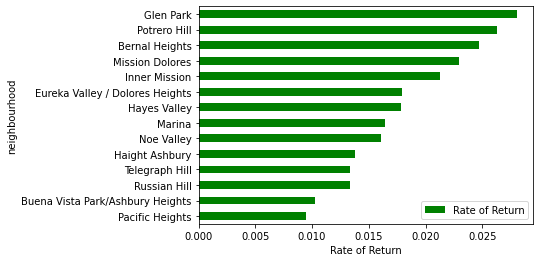

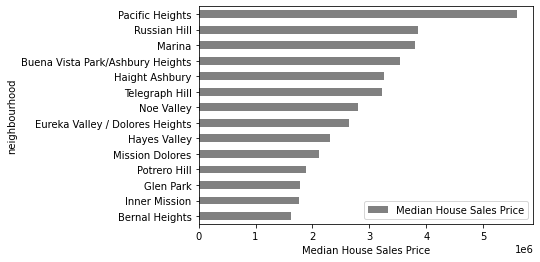

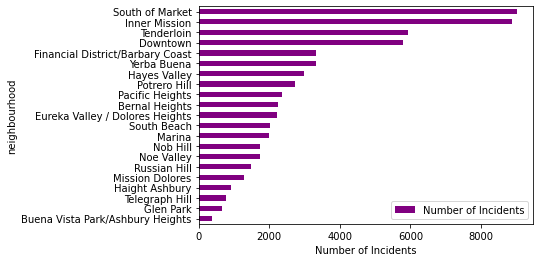

In [390]:
# Gross Income
#df_filter.sort_values(by=['Gross Income']).plot(x='neighbourhood', y='Gross Income', kind='barh', color='blue')
#plt.xlabel('Gross Income($)')

# Rate of return 
df_filter.sort_values(by=['Rate of Return']).head(14).plot(x='neighbourhood', y='Rate of Return', kind='barh', color='green')
plt.xlabel('Rate of Return')

# Median house price 
df_filter.sort_values(by=['Median House Sales Price']).head(14).plot(x='neighbourhood', y='Median House Sales Price', kind='barh', color='gray')
plt.xlabel('Median House Sales Price')

# Number of incidents
df_filter.sort_values(by=['Number of Incidents']).plot(x='neighbourhood', y='Number of Incidents', kind='barh', color='purple')
plt.xlabel('Number of Incidents')

plt.show()

**Rank of Neighbourboods by Annual Gross Income, Annual Rate of Return, Median House Price**

| Rank | Neighborhoods | Annual Gross Income | Rank | Neighborhoods | Annual Rate of Return | Rank | Neighborhoods | Median House Sales Price |
| --- | --- | --- | --- | --- | --- | --- | --- | --- |
| 1 | Marina | 62500 | 1 | Glen Park | 0.0280986 | 1 | Pacific Heights | 5600000 |
| 2 | Pacific Heights | 53250 | 2 | Potrero Hill | 0.0263228 | 2| Russian Hill | 3850000 |
| 3	| Russian Hill | 51250 | 3 | Bernal Heights | 0.0246761 | 3| Marina | 3800000 |
| 4	| Glen Park | 49875 | 4	| Mission Dolores |	0.0229858 | 4 | Buena Vista Park/Ashbury Heights | 3540000 |
| 5	| Potrero Hill | 49750 | 5 |Inner Mission | 0.0212465 | 5| Haight Ashbury | 3250000 |
| 6	| Mission Dolores | 48500 | 6 |Eureka Valley / Dolores Heights | 0.0179584 | 6 | Telegraph Hill | 3222500 |
| 7	| Eureka Valley / Dolores Heights |	47500 | 7 | Hayes Valley | 0.0178378 | 7 |Noe Valley | 2800000 |
| 8	| Downtown | 47000 | 8 | Marina | 0.0164474 | 8 | Eureka Valley / Dolores Heights | 2645000 |
| 9	| Noe Valley | 45000 | 9 | Noe Valley | 0.0160714 | 9|  Hayes Valley | 2312500 |
| 10 | Haight Ashbury | 44750 | 10 | Haight Ashbury | 0.0137692 | 10 | Mission Dolores | 2110000 |
| 11 | Yerba Buena | 44500 | 11 | Telegraph Hill | 0.0133825 | 11| Potrero Hill | 1890000 |
| 12 | South Beach | 44250 | 12 | Russian Hill | 0.0133117 | 12 | Glen Park | 1775000 |
| 13 | South of Market | 43750 | 13 | Buena Vista Park/Ashbury Heights | 0.0102401 | 13 | Inner Mission | 1765000 |
| 14 | Telegraph Hill | 43125 | 14 | Pacific Heights | 0.00950893 | 14 | Bernal Heights | 1621000 |
| 15 | Hayes Valley | 41250 | 


**Methodology /Assumptions:**
- Rate of Return = Estimated Annual Gross Income / Median House Price(Year 2020). 
- Assume annual occupancy rate of 68%, meaning the house can be rented out 250 days in a year.
- We'll compare the return rate across different neighborhoods to choose the one with high return rate within the budget. 

### Insights: 

Which Neighborhood is best for investment?  It depands on the budget and safety of the neighborhood.

>Budgets below $2,000,000:
- Glen Park has the highest return rate and fewer incidents. It would be a good investment with high return rate and being safe. The median house price is \\$1,775,000 for this neighborhood in 2020, good for investors with budget below \\$2,000,000. 
- Bernal Heights has sightly lower return rate than Glen Park, and it's not on the dangerous list. It's another good neighbodhood to invest with budget below \\$2,000,000.
- Potrero Hill has the second highest return rate, but it's the 10th on the dangerous list.
- Among Top 15 neighborhoods with high return rate,  Inner Mission has the highest number of incidents.  It may not be a safe neighborhood. 

>Budgets above $2,000,000:
- Mission Dolores has high return rate and is a safe neighborhood based on low number of incidents. 
- Hayes Valley and Eureka Valley / Dolores Heights are both among neighborhoods with large number of incidents.

*Note: 
1. We only use gross income and ignore operating cost due to the availability of data.
2. House price data is not available for some neighborhoods. Null values are excluded. 
3. Many of the popular neighbourhoods have large number of incidents, however the incidents report contains all incident categories and can only be used as a reference.

### 5. What are the most common words used in listing names? I can use them as a reference when listing my own house. 

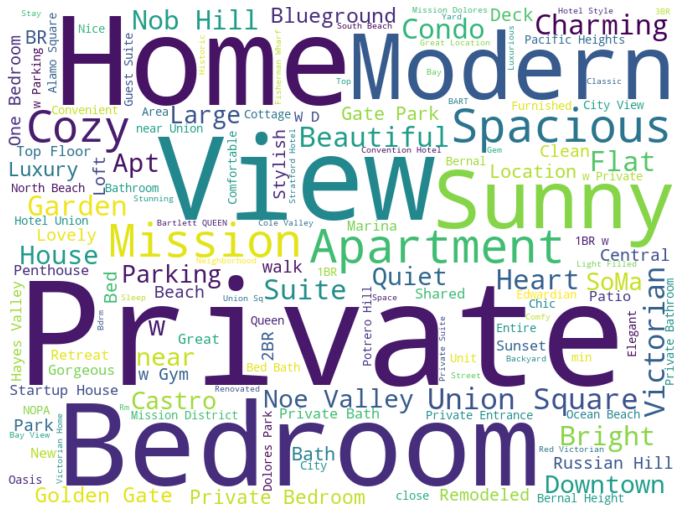

In [222]:
# wordcloud image
plt.figure(figsize = (12,12))
text = ' '.join(name for name in df_detail.name)

# Create stopword list:
stopwords = set(STOPWORDS)
stopwords.update(['SF', 'san', 'francisco', 'Room', 'studio'])
#'Room', 'House', 'Studio', 'bedroom', 'home'

# Generate a word cloud image
wordcloud = WordCloud(stopwords=stopwords, background_color='white', width=800, height=600,min_font_size=10).generate(text)

# Display the generated image:
# the matplotlib way:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

### Insights:
>Through wordcloud, we can find out popular words used in listing names. I excluded 'San Francisco', 'Room' and 'studio' from the list. We can draw several conclusions from the wordcloud above:
- Most commonly used words are: private, home, bedroom, sunny, view, modern, spacious, apartment, cozy, beautiful, charming, heart, luxury, etc. Those words describe the house itself. 
- Private is the most used word meaning privacy is an important factor that visitors consider when rent a house from Airbnb. 
- Popular descriptive words hosts use are: modern, view, sunny, spacious, cozy, Victorian, charming, beautiful, bright
- Some location words such as Mission, Union Square, Golden Gate, beach, downtown shows places visitors like to stay or visit

<a id='conclusions'></a>
## VI. Conclusions

1. Listing entire home/apt and private room are two major listing types. More than 60% of listings are Entire home/apt, with about 34% being listed as Private rooms. The rest are Shared rooms (3%) and Hotel room (1.3%).
2. Renting the entire home/apt makes more money than listing rooms separately and is earier to manage. 
3. A solidly booked Airbnb listing can be more profitable than renting the same property in the traditional way. The more the number of bedrooms, the lower the break-even occupancy rate. When the annual occupancy rate is higher than the break-even point, Airbnb makes the most money. When occupancy rate is lower than the break-even point, traditional renting is more profitble. 
4. 75% of the hosts have one listing and entire home/apt is the major listing type. Short_term renting less than 25 days is popular among single listing hosts. 
5. For budget below \\$2,000,000, Glen Park is the best investment with median house price \\$1,775,000 and the highest annual rate of return 2.8%, and also being safe. Bernal Heights has sightly lower return rate than Glen Park and it has fewer incidents too. Potrero Hill has the second highest return rate, but it's the 10th on the list of neighborhoods with most incidents. Among Top 15 neighborhoods with high return rate,  Inner Mission has the highest number of incidents.  It may not be a safe neighborhood. For budget above $2,000,000, Mission Dolores has high return rate and is a safe neighborhood based on low number of incidents. Hayes Valley and Eureka Valley / Dolores Heights are both among neighborhoods with large number of incidents.
6. Commonly used words are private, home, bedroom, sunny, view, modern, spacious, apartment, cozy, beautiful, charming, heart, luxury, etc. - Popular descriptive words hosts use are: modern, view, sunny, spacious, cozy, Victorian, charming, beautiful, bright. Private is the most used word meaning privacy is an important factor that visitors consider.  Location words such as Mission, Union Square, Golden Gate, beach, downtown shows places visitors like to stay or visit.

## Limitations:
- Median house price is not available for some neighborhoods.
- Crime data can only be used as a reference because the data includes all incidents categories, some of which are not relevant to the safety and quality of life in the neighborhood. Only violent and property crime incidents should be used. Besides, population density is not considered. We only use the number of crime incidents for this analysis but it was not scaled to the population in each neighborhood to get a crime rate, for example, the number of crime incidents per thousand residents that could be compared across neighborhoods. 

## References:

<br>https://thispointer.com/python-how-to-unzip-a-file-extract-single-multiple-or-all-files-from-a-zip-archive/
<br>https://stackoverflow.com/questions/12860421/python-pandas-pivot-table-with-aggfunc-count-unique-distinct
<br>https://pstblog.com/2016/10/04/stacked-charts
<br>https://stackoverflow.com/questions/35523635/extract-values-in-pandas-value-counts/35523820
<br>https://stackoverflow.com/questions/52436394/how-to-convert-a-pandas-value-counts-into-a-python-list
<br>https://stackoverflow.com/questions/47136436/python-pandas-convert-value-counts-output-to-dataframe/47136484
<br>https://seaborn.pydata.org/generated/seaborn.countplot.html
<br>https://www.geeksforgeeks.org/selecting-rows-in-pandas-dataframe-based-on-conditions/
<br>https://stackoverflow.com/questions/45759966/counting-unique-values-in-a-column-in-pandas-dataframe-like-in-qlik
<br>https://datatofish.com/pie-chart-matplotlib/
<br>https://stackoverflow.com/questions/46623583/seaborn-countplot-order-categories-by-count
<br>https://stackoverflow.com/questions/19952290/how-to-align-the-bar-and-line-in-matplotlib-two-y-axes-chart
<br>https://www.kaggle.com/alexisbcook/interactive-maps
<br>https://jingwen-z.github.io/how-to-draw-a-variety-of-maps-with-folium-in-python/
<br>https://www.datacamp.com/community/tutorials/wordcloud-python
<br>https://geopandas.readthedocs.io/en/latest/gallery/create_geopandas_from_pandas.html
<br>https://stackoverflow.com/questions/38516481/trying-to-remove-commas-and-dollars-signs-with-pandas-in-python
<br>https://stackoverflow.com/questions/48655801/tables-in-markdown-in-jupyter
<br>http://lukepiccolo.com/articles/2017/1/17/should-you-list-your-airbnb-as-a-private-room-or-entire-place
<br>https://stackoverflow.com/questions/23981601/format-certain-floating-dataframe-columns-into-percentage-in-pandas
<br>https://www.geeksforgeeks.org/get-n-largest-values-from-a-particular-column-in-pandas-dataframe/
<br>https://stackoverflow.com/questions/58272872/pandas-top-n-values-in-each-group
<br>https://blog.softhints.com/display-two-pandas-dataframes-side-by-side-jupyter-notebook/#solution2renderdataframessidebysidebycssoverridewithindex
<br>https://www.thebalance.com/pros-and-cons-of-airbnb-as-an-investment-strategy-4776231#citation-2
<br>http://lukepiccolo.com/articles/2017/1/17/should-you-list-your-airbnb-as-a-private-room-or-entire-place
<br>https://sharedeconomycpa.com/blog/airbnb-vs-renting/
<br>https://www.thebalance.com/pros-and-cons-of-airbnb-as-an-investment-strategy-4776231#citation-2
<br>https://robertmitchellv.com/blog-bar-chart-annotations-pandas-mpl.html
<br>https://www.neighborhoodscout.com/ca/san-francisco/crime#description
<br>https://victorysharaf.medium.com/san-francisco-neighborhood-analysis-2c7849f4c520